In [15]:
import os
import csv
import numpy as np
import random

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from skimage import data,exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [2]:
# cv => train:val = 4:1
mon = os.listdir('/home/stevenlai/Desktop/chexnet/database/MON/')
TB = []
non_TB = []

for pngname in mon:
    if pngname.split('.')[0].split('_')[-1] == '0':
        non_TB.append(pngname)
    else:
        TB.append(pngname)
print('TB image(should be 58):',len(TB))
print('non_TB image(should be 80):',len(non_TB))

# Shuffle the list
random.seed(10)  
random.shuffle(TB)
random.shuffle(non_TB)

# open csv
traincsv = open('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/train.csv','w')
trainwriter = csv.writer(traincsv)
trainwriter.writerow(['path','label'])


testcsv = open('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/test.csv','w')
testwriter = csv.writer(testcsv)
testwriter.writerow(['path','label'])

# TB:9 for test
# non TB: 13 for test
for i in range(len(TB)):
    if i < 9:
        testwriter.writerow(['MON/'+TB[i],1])
    else:
        trainwriter.writerow(['MON/'+TB[i],1])
    
for i in range(len(non_TB)):
    if i < 13:
        testwriter.writerow(['MON/'+non_TB[i],0])
    else:
        trainwriter.writerow(['MON/'+non_TB[i],0])

traincsv.close()
testcsv.close()

TB image(should be 58): 58
non_TB image(should be 80): 80


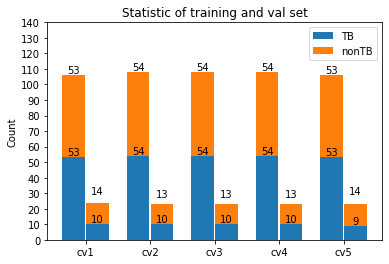

In [3]:
# read in csv and do k fold
df = pd.read_csv('/home/stevenlai/Desktop/chexnet_tensorflow/MON/dataset/train.csv')
X = df[['path']]
Y = df[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
trTB = []
trnTB = []
valTB = []
valnTB = []

for x,y in skf.split(X,Y):
    TB_count = 0
    non_TB_count = 0
    
    val_TB_count = 0
    val_non_TB_count = 0
    
    #print('train(~=92):',len(x))
    #print('val(~=24):',len(y))
    
    for i in x:
        if (Y.iloc[i,0]) == 1:
            TB_count += 1
        else:
            non_TB_count += 1
    #print('TB:',TB_count)
    #trTB.append(TB_count)
    #print('non TB:',non_TB_count)
    #trnTB.append(non_TB_count)
    #print()
    
    # imbalance by simply adding up
    imbalance = non_TB_count - TB_count
    #print(non_TB_count,TB_count)
    add = 0
    for i in range(len(x)):
        #print(Y.iloc[x[i]][0])
        if Y.iloc[x[i]][0] == 1:
            x = np.append(x,x[i])
            #print(len(x))
            #print(X.iloc[x[i]][0])
            add += 1
        if add == imbalance:
            break
            
    TB_count = 0
    non_TB_count = 0           
    for i in x:
        if (Y.iloc[i,0]) == 1:
            TB_count += 1
        else:
            non_TB_count += 1
    #print('TB:',TB_count)
    trTB.append(TB_count)
    #print('non TB:',non_TB_count)
    trnTB.append(non_TB_count)
    #print()    
    
    
    for i in y:
        if (Y.iloc[i,0]) == 1:
            val_TB_count += 1
        else:
            val_non_TB_count += 1
    #print('TB:',TB_count)
    valTB.append(val_TB_count)
    #print('non TB:',non_TB_count)
    valnTB.append(val_non_TB_count)
    #print()
    
# bar plot
labels = ['cv1','cv2','cv3','cv4','cv5']
N = 5

ind = np.arange(N)  
width = 0.35       
x = np.arange(len(labels)) 
p1 = plt.bar(x - width/2 - 0.01, trTB, width ,label='TB')
p2 = plt.bar(x - width/2 - 0.01, trnTB, width, bottom = trTB,label='non TB')
p3 = plt.bar(x + width/2 + 0.01, valTB, width, color=p1[0].get_facecolor())
p4 = plt.bar(x + width/2 + 0.01, valnTB, width, bottom = valTB,label='non TB',
            color=p2[0].get_facecolor())

plt.ylabel('Count')
plt.title('Statistic of training and val set')
plt.xticks(ind,labels)
plt.yticks(np.arange(0, 141, 10))
plt.legend()
plt.legend((p1[0], p2[0]), ('TB', 'nonTB'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.*height,
                '%d' % int(height),
                ha='center', va='bottom')
def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 2.0*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(p1)
autolabel2(p2)
autolabel(p3)
autolabel2(p4)

plt.show()

In [286]:
from skimage.io import imread
from skimage.transform import rescale, resize

In [10]:
# file:///home/stevenlai/Downloads/28288-31036-1-PB.pdf
# http://europepmc.org/article/PMC/4335146
def CLAHE(img):
    img = img[:,:,0]
    img = img / 255
    #p2, p98 = np.percentile(img, (2, 98))
    #img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    img_adapteq = np.expand_dims(img_adapteq,axis=2)
    return img_adapteq

train_datagen = ImageDataGenerator(zoom_range = 0.1,
                                   preprocessing_function=CLAHE)

Found 92 validated image filenames belonging to 2 classes.
(224, 224, 1)
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.]


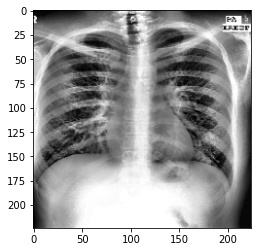

In [14]:
image_dir = '/home/stevenlai/Desktop/chexnet/database/'
df['label'] = df['label'].astype(str)
for train_index, val_index in skf.split(X,Y):
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    
    train_data_generator = train_datagen.flow_from_dataframe(training_data, 
                                                             directory = image_dir,
                                                             x_col = "path", 
                                                             y_col = "label",
                                                             class_mode = "sparse" ,
                                                             shuffle = True,
                                                             color_mode = 'grayscale',
                                                             target_size = (224,224),
                                                             batch_size = 16,
                                                             seed = 10)
    for (x,y) in train_data_generator :
        print(x[0].shape)
        print(y)
        plt.imshow(x[0][:,:,0], cmap=plt.cm.gray)
        plt.show()
        break
    break

In [20]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable=False
top_model = tf.keras.models.Sequential()
top_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(tf.keras.layers.Dropout(0.5))
top_model.add(tf.keras.layers.Dense(64, kernel_initializer='normal'))
top_model.add(tf.keras.layers.BatchNormalization())
top_model.add(tf.keras.layers.Activation('relu'))
top_model.add(tf.keras.layers.Dense(64, kernel_initializer='normal'))
top_model.add(tf.keras.layers.BatchNormalization())
top_model.add(tf.keras.layers.Activation('relu'))
top_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model = tf.keras.models.Model(base_model.inputs, top_model(base_model.output))
#model.summary()

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['loss'])

In [ ]:
reduce_lr = ReduceLROnPlateau(factor = 0.5,
                              monitor = 'val_loss',
                              min_lr = 0.000001,
                              patience = 10,
                              verbose = 1)